# 项目：巴西预约挂号数据集分析
## 目录
<ul>
    <li><a href='#intro'>简介</a></li>
    <li><a href='#wrangling'>数据整理</a></li>
    <li><a href='#eda'>探索性数据分析</a></li>
    <li><a href='#conclusions'>结论</a></li>
    <li><a href='#afterword'>后记</a></li>
</ul>

<a id='intro'></a>
## 一. 简介
本数据集包含10万条巴西预约挂号的求诊信息(来自<a href='https://www.kaggle.com/joniarroba/noshowappointments'>Kaggle</a>的原始数据)，研究病人是否如约前往医院就诊。每行数据录入了有关患者特点的多个数值，包括 “预约日期 (ScheduledDay)”指患者具体预约就诊的日期；“街区 (Neighborhood) ”指医院所在位置；“福利保障 (Scholarship)”说明病人是否是巴西福利项目Bolsa Família的保障人群；最后一列内容：“No”表示病人已如约就诊，“Yes”说明病人未前往就诊。

该项目拟研究：
- 一周内随着日期的不同，预约数量如何变化？
- 预约人群的年龄分布如何？不同性别的年龄分布又如何，是否有差异？
- 哪种性别的患者预约数量更多
- 哪些因素能够帮助预测患者是否会按照其挂号预约前往医院就诊？其中哪些因素具有较强相关性，哪些因相关性较弱？

In [1]:
# 导入需要用到的包
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# 数据可视化相关设置
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

<a id='wrangling'></a>
## 二. 数据整理
本数据集需要进行的清理工作包括：
- 清理列标签
- 丢空，去重，去除异常值
- 转换数据类型
- 提取特征值

In [2]:
# 读取数据
data = pd.read_csv('KaggleV2-May-2016.csv')
# 打印前三行
data.head(3)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No


In [3]:
# 数据集大小
data.shape

(110527, 14)

### 2.1 清理列标签
将列标签统一改为小写字母，并且改正其中的拼写错误。

In [4]:
# 将大写字母转为小写字母，将中横线转为下划线
data.columns = data.columns.str.lower().str.replace('-','_')
print(data.columns)

# 两个单词之间添加下划线，改正拼写错误
cols = {'patientid':'patient_id', 'appointmentid':'appointment_id', 'scheduledday':'scheduled_day', 'appointmentday':'appointment_day', 'hipertension':'hypertension', 'handcap':'handicap'}
data.rename(columns=cols, inplace=True)
print(data.columns)

Index(['patientid', 'appointmentid', 'gender', 'scheduledday',
       'appointmentday', 'age', 'neighbourhood', 'scholarship', 'hipertension',
       'diabetes', 'alcoholism', 'handcap', 'sms_received', 'no_show'],
      dtype='object')
Index(['patient_id', 'appointment_id', 'gender', 'scheduled_day',
       'appointment_day', 'age', 'neighbourhood', 'scholarship',
       'hypertension', 'diabetes', 'alcoholism', 'handicap', 'sms_received',
       'no_show'],
      dtype='object')


### 2.2 转换数据类型
将表示时间的数据改为时间类型。

In [5]:
data.head(3)

,patient_id,appointment_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No


In [6]:
# 查看数据类型
data.dtypes

patient_id         float64
appointment_id       int64
gender              object
scheduled_day       object
appointment_day     object
age                  int64
neighbourhood       object
scholarship          int64
hypertension         int64
diabetes             int64
alcoholism           int64
handicap             int64
sms_received         int64
no_show             object
dtype: object

In [7]:
# 转换时间类型
data['scheduled_day'] = pd.to_datetime(data['scheduled_day'])
data['appointment_day'] = pd.to_datetime(data['appointment_day'])

print(data['scheduled_day'].head(3))
print(data['appointment_day'].head(3))

0   2016-04-29 18:38:08
1   2016-04-29 16:08:27
2   2016-04-29 16:19:04
Name: scheduled_day, dtype: datetime64[ns]
0   2016-04-29
1   2016-04-29
2   2016-04-29
Name: appointment_day, dtype: datetime64[ns]


### 2.3 丢空，去重，去除异常值
检查数据中是否存在缺失值，重复值和异常值。经检查发现没有重复值和缺失值，只有异常值。

In [8]:
# 查看是否有重复值
sum(data.duplicated())

0

无重复值。

In [9]:
# 查看是否有缺失数据或异常数据 
print(data.info()) # 不同值的个数
print('---------') 
print('gender', data['gender'].unique())
print('age', sorted(data['age'].unique()))
print('scholarship', data['scholarship'].unique())
print('hypertension', data['hypertension'].unique())
print('diabetes', data['diabetes'].unique())
print('alcoholism', data['alcoholism'].unique())
print('handicap', data['handicap'].unique())
print('sms_received', data['sms_received'].unique())
print('no_show', data['no_show'].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
patient_id         110527 non-null float64
appointment_id     110527 non-null int64
gender             110527 non-null object
scheduled_day      110527 non-null datetime64[ns]
appointment_day    110527 non-null datetime64[ns]
age                110527 non-null int64
neighbourhood      110527 non-null object
scholarship        110527 non-null int64
hypertension       110527 non-null int64
diabetes           110527 non-null int64
alcoholism         110527 non-null int64
handicap           110527 non-null int64
sms_received       110527 non-null int64
no_show            110527 non-null object
dtypes: datetime64[ns](2), float64(1), int64(8), object(3)
memory usage: 11.8+ MB
None
---------
gender ['F' 'M']
age [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,

很明显，没有空缺值，但是年龄特征中出现了异常值-1岁，查看该条数据并将其删除。

In [10]:
# 查看异常数据
print(data[data.age == -1])
print(data[data.age == -1].shape)

# 删除异常数据
data.drop(99832, axis=0, inplace=True)
# 删除之后数据大小
print('data_shape', data.shape)

         patient_id  appointment_id gender       scheduled_day  \
99832  4.659432e+14         5775010      F 2016-06-06 08:58:13   

      appointment_day  age neighbourhood  scholarship  hypertension  diabetes  \
99832      2016-06-06   -1         ROMÃO            0             0         0   

       alcoholism  handicap  sms_received no_show  
99832           0         0             0      No  
(1, 14)
data_shape (110526, 14)


### 2.4 增加特征
**增加星期特征：**从预约的就诊日期中提取星期几信息，并增加至<code>data.day_of_week</code>中。

**说明：**数字1到7分别对应星期一到星期日。

In [11]:
data['day_of_week'] = data['appointment_day'].apply(lambda x: x.weekday()+1)
data.head(3)

,patient_id,appointment_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show,day_of_week
0,2.987250e+13,5642903,F,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No,5
1,5.589978e+14,5642503,M,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No,5
2,4.262962e+12,5642549,F,2016-04-29 16:19:04,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No,5


**增加是否按预约就诊特征：**从no_show中提取该信息，并增加至<code>data.if_show</code>中。

**说明：**1代表按照预约就诊，0代表没有按照预约就诊。

In [12]:
# 增加数据列if_show，按时就诊设为1，没有就诊设为0
data['if_show'] = data.no_show.str.replace('No', '1').str.replace('Yes', '0').astype(int)
data.head(3)

,patient_id,appointment_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show,day_of_week,if_show
0,2.987250e+13,5642903,F,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No,5,1
1,5.589978e+14,5642503,M,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No,5,1
2,4.262962e+12,5642549,F,2016-04-29 16:19:04,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No,5,1


### 2.5 删除无用特征
删除特征<code>appointment_id</code>,<code>scheduled_day</code>,<code>appointment_day</code>,<code>no_show</code>

In [13]:
data.drop(columns=['appointment_id','scheduled_day','appointment_day','no_show'], inplace=True)
data.head(3)

,patient_id,gender,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,day_of_week,if_show
0,2.987250e+13,F,62,JARDIM DA PENHA,0,1,0,0,0,0,5,1
1,5.589978e+14,M,56,JARDIM DA PENHA,0,0,0,0,0,0,5,1
2,4.262962e+12,F,62,MATA DA PRAIA,0,0,0,0,0,0,5,1


<a id='eda'></a>
## 三. 探索性数据分析

### 3.1 一周内随着日期的不同，预约数量如何变化？

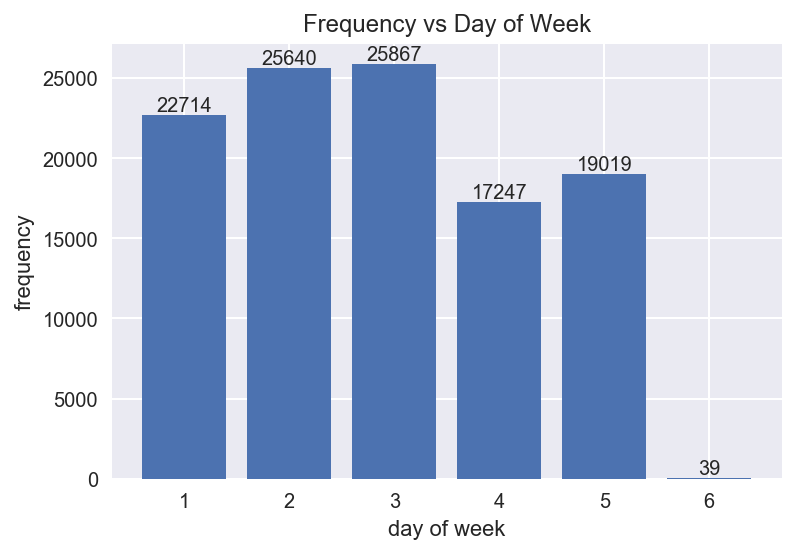

In [14]:
# 对不同星期的数据进行统计
fig_data = data['day_of_week'].value_counts()

plt.bar(x=fig_data.index, height=fig_data)
plt.title('Frequency vs Day of Week')
plt.xlabel('day of week')
plt.ylabel('frequency')

# 添加数值大小
for x,y in fig_data.items():
    plt.text(x, y, '%.0f'%y, ha='center', va= 'bottom')

plt.show()

观察上图可知，患者的预约集中在工作日，而周六的预约人次微乎其微，周日则没有预约。其中工作日的预约，周一到周三每天的预约人次高于周四和周五的预约人次。

### 3.2 预约人群的年龄分布如何？不同性别的年龄分布又如何，是否有差异？

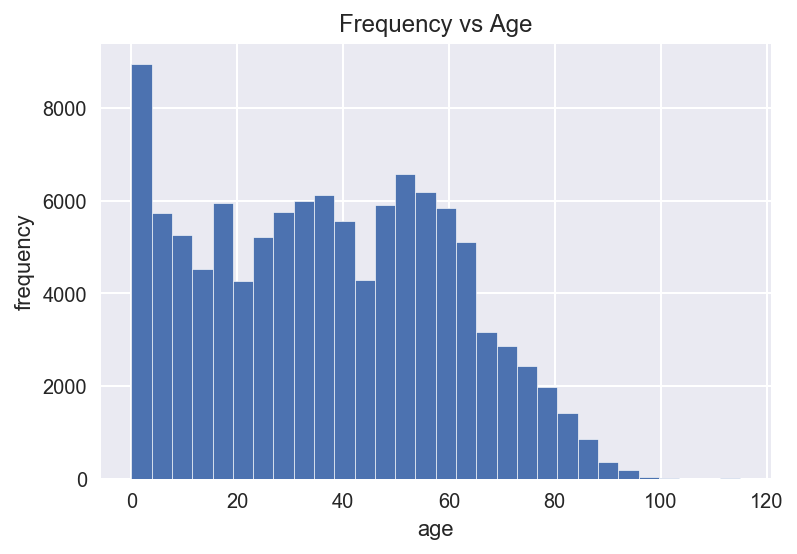

In [15]:
data.age.hist(bins=30, edgecolor='white')
plt.title('Frequency vs Age')
plt.xlabel('age')
plt.ylabel('frequency');

预约患者的年龄分布呈右偏态分布，患者预约数量集中在0到60岁年龄段。

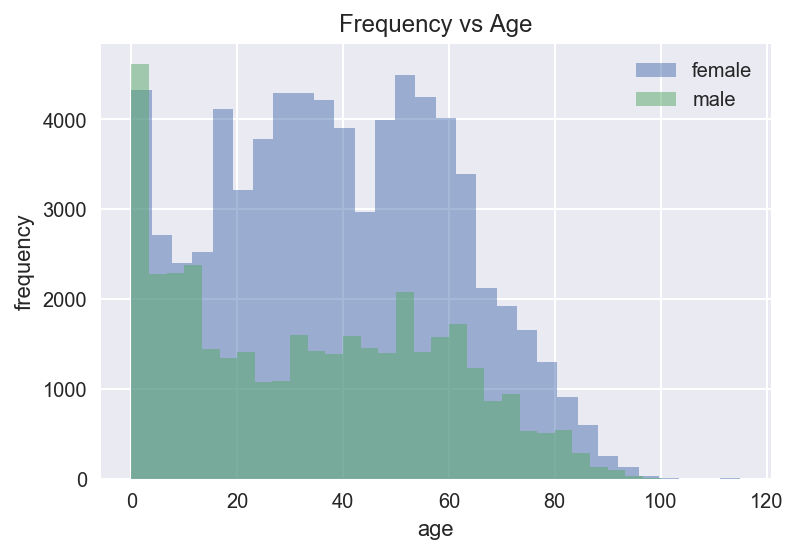

In [16]:
data.age[data.gender == 'F'].hist(alpha=0.5, bins=30, label='female')
data.age[data.gender == 'M'].hist(alpha=0.5, bins=30, label='male')
plt.legend()
plt.title('Frequency vs Age')
plt.xlabel('age')
plt.ylabel('frequency');

不同性别的年龄分布略有差异，女性患者在20岁到60岁之间预约的最密集，男性患者则在20岁以下预约的更频繁。

### 3.3 哪种性别的患者预约数量更多？

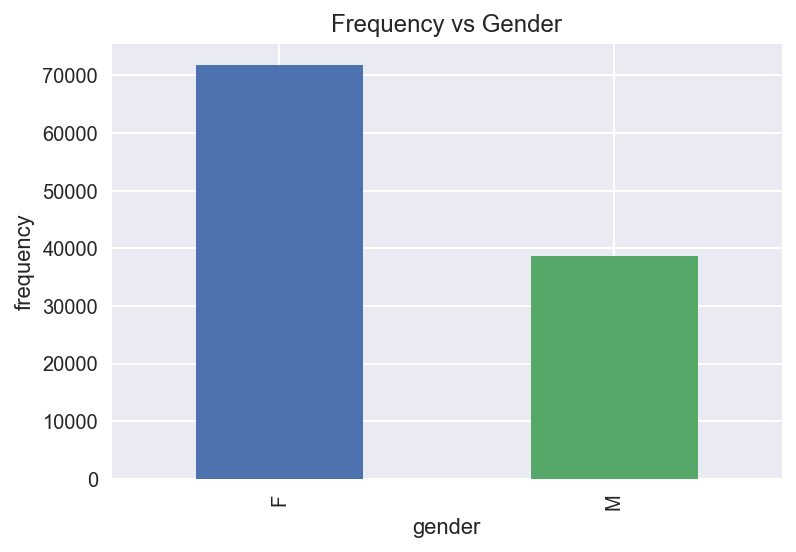

In [17]:
data.groupby('gender').patient_id.count().plot(kind='bar')
plt.title('Frequency vs Gender')
plt.xlabel('gender')
plt.ylabel('frequency');

明显女性患者的预约人次更高，大致是男性患者的两倍。说明巴西女性相较男性而言，更关心自身的健康。

### 3.4 哪些因素影响病人是否按约就诊？

拟研究的因素包括：
- 是否收到短信(sms_received)
- 是否享受福利(scholarship)
- 是否患高血压(hypertension)
- 医院所在街区(neighbourhood)
- 是否患糖尿病(diabetes)
- 性别(gender)
- 是否酗酒(alcoholism)

下面对这些特征逐一进行研究。

#### 3.4.1 是否收到短信

In [18]:
data.head()

,patient_id,gender,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,day_of_week,if_show
0,2.987250e+13,F,62,JARDIM DA PENHA,0,1,0,0,0,0,5,1
1,5.589978e+14,M,56,JARDIM DA PENHA,0,0,0,0,0,0,5,1
2,4.262962e+12,F,62,MATA DA PRAIA,0,0,0,0,0,0,5,1
3,8.679512e+11,F,8,PONTAL DE CAMBURI,0,0,0,0,0,0,5,1
4,8.841186e+12,F,56,JARDIM DA PENHA,0,1,1,0,0,0,5,1


sms_received
0    75044
1    35482
Name: if_show, dtype: int64

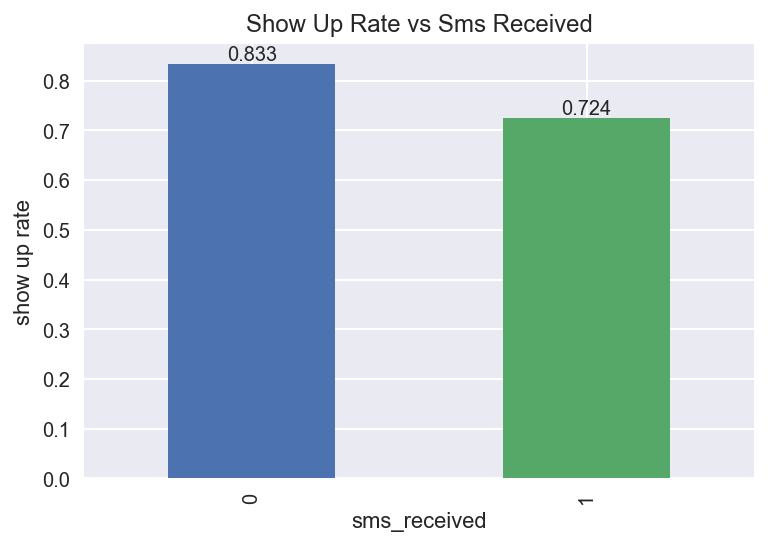

In [19]:
# 获取统计数据
fig_data = data.groupby('sms_received').if_show.mean()

fig_data.plot(kind='bar')
plt.title('Show Up Rate vs Sms Received')
plt.ylabel('show up rate')

# 添加数值大小,保留两位小数
for x,y in fig_data.items():
    plt.text(x, y, '%.3f'%y, ha='center', va= 'bottom')

# 收到短信与否的人次
data.groupby('sms_received').if_show.count()

没有收到短信的病人的就诊率比收到短信的就诊率高出10.9%，说明就诊率和是否收到短信之间具有较明显的相关性。

#### 3.4.2 是否享受福利保障

scholarship
0    99665
1    10861
Name: if_show, dtype: int64

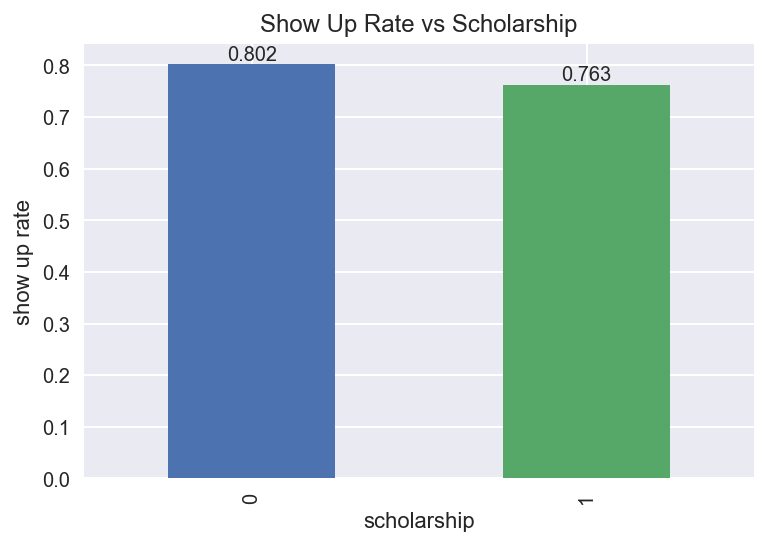

In [20]:
# 获取统计数据
fig_data = data.groupby('scholarship').if_show.mean()

fig_data.plot(kind='bar')
plt.title('Show Up Rate vs Scholarship')
plt.ylabel('show up rate')

# 添加数值大小,保留两位小数
for x,y in fig_data.items():
    plt.text(x, y, '%.3f'%y, ha='center', va= 'bottom')

# 受到福利保障与否的人次
data.groupby('scholarship').if_show.count()

没有受到福利保障的病人的就诊率比受到福利保障的病人的就诊率高出3.9%，说明就诊率和是否受到福利保障之间具有相关性。

#### 3.4.3 排除福利保障因素影响，再查看是否收到短信对就诊率的影响

scholarship  sms_received
0            0               67688
             1               31977
1            0                7356
             1                3505
Name: if_show, dtype: int64
scholarship  sms_received
0            0               0.835407
             1               0.731057
1            0               0.810495
             1               0.662197
Name: if_show, dtype: float64


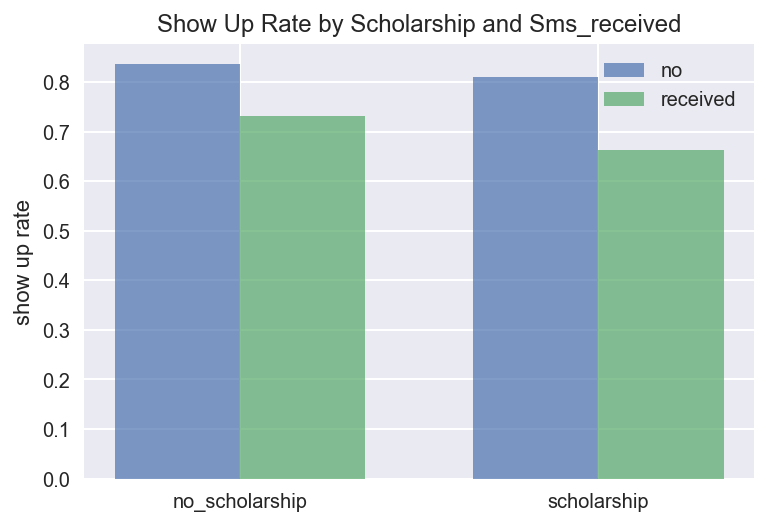

In [21]:
# 打印分组数据
print(data.groupby(['scholarship','sms_received']).if_show.count())
print(data.groupby(['scholarship','sms_received']).if_show.mean())

# 获取分组数据
if_show = data.groupby(['scholarship','sms_received']).if_show.mean()
data1 = [if_show[0][0], if_show[1][0]]
data2 = [if_show[0][1], if_show[1][1]]

ind = np.arange(2)
width = 0.35
plt.bar(ind, data1, width, alpha=.7, label='no')
plt.bar(ind+width, data2, width, alpha=.7, label='received')

# 标题和标签
plt.ylabel('show up rate')
plt.title('Show Up Rate by Scholarship and Sms_received')
pos = ind + width / 2
labels = ['no_scholarship', 'scholarship']
plt.xticks(pos, labels)

# 图例
plt.legend();

在排除是否享受福利这一因素的影响下，没有收到短信的就诊率仍然比收到短信的就诊率高，在各分组内分别高出10%和15%，说明就诊率与是否收到短信具有较强的相关性。

#### 3.4.4 是否患高血压

hypertension
0    88725
1    21801
Name: if_show, dtype: int64


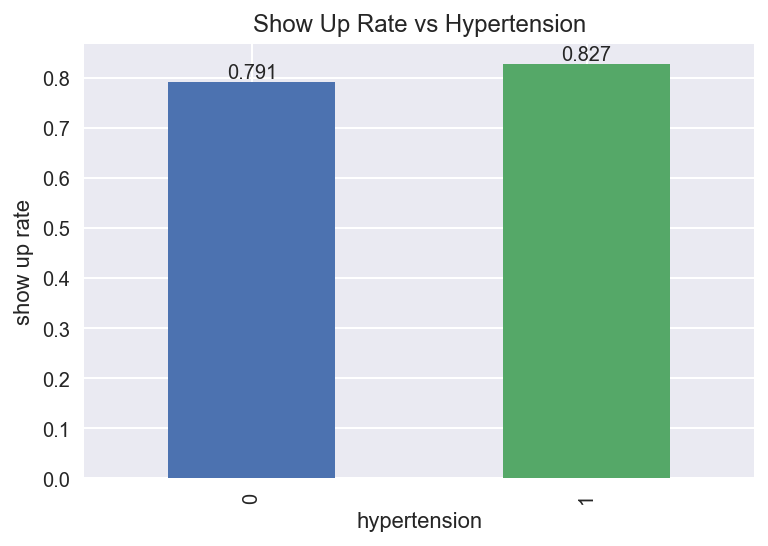

In [22]:
# 打印患高血压与否的人次
print(data.groupby('hypertension').if_show.count())

# 获取统计数据
fig_data = data.groupby('hypertension').if_show.mean()

fig_data.plot(kind='bar')
plt.title('Show Up Rate vs Hypertension')
plt.ylabel('show up rate')

# 添加数值大小,保留两位小数
for x,y in fig_data.items():
    plt.text(x, y, '%.3f'%y, ha='center', va= 'bottom')

患高血压的病人的就诊率比没有患高血压的病人的就诊率高出3.6%，说明就诊率和是否享受福利保障之间具有相关性。

#### 3.4.5 不同街区的就诊率

In [23]:
data.groupby('neighbourhood').if_show.mean().sort_values(ascending=False)

neighbourhood
PARQUE INDUSTRIAL              1.000000
ILHA DO BOI                    0.914286
AEROPORTO                      0.875000
MÁRIO CYPRESTE                 0.854447
SOLON BORGES                   0.852878
DE LOURDES                     0.845902
DO CABRAL                      0.842857
SANTA MARTHA                   0.841584
JARDIM DA PENHA                0.837245
DO QUADRO                      0.835100
VILA RUBIM                     0.834313
MORADA DE CAMBURI              0.833333
MATA DA PRAIA                  0.829193
REPÚBLICA                      0.828743
CONSOLAÇÃO                     0.827762
PONTAL DE CAMBURI              0.826087
SANTO ANTÔNIO                  0.823744
REDENÇÃO                       0.822923
NOVA PALESTINA                 0.822438
JABOUR                         0.820247
SANTA LUÍZA                    0.820093
COMDUSA                        0.819355
JOANA D´ARC                    0.819201
TABUAZEIRO                     0.817050
FORTE SÃO JOÃO            

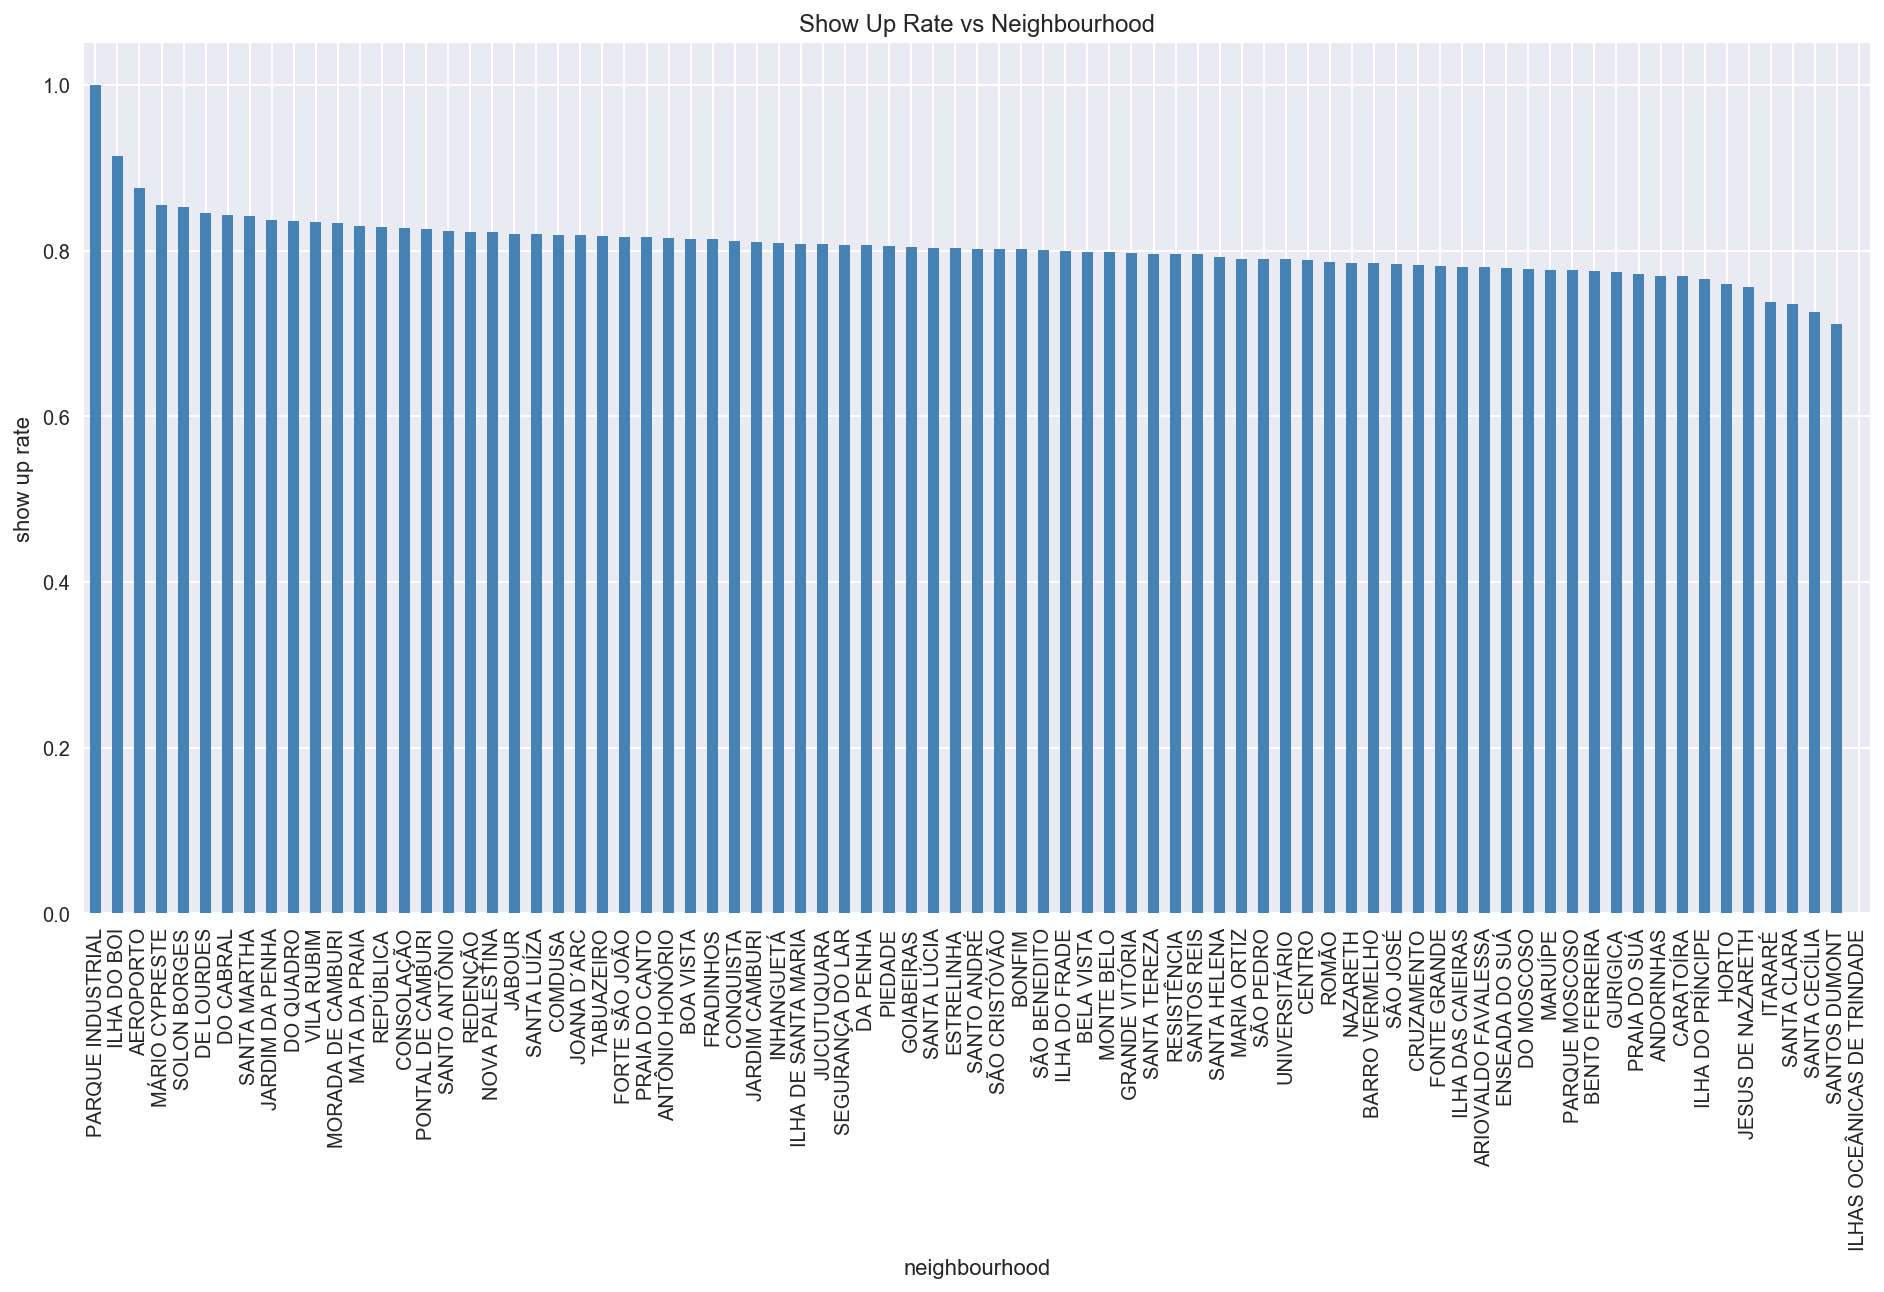

In [24]:
# 设置画布大小
plt.figure(figsize=(16,8))
# 将街区就诊率按照从大到小排列
ind = data.groupby('neighbourhood').if_show.mean().sort_values(ascending=False).index
data.groupby('neighbourhood').if_show.mean()[ind].plot(kind='bar', color='steelblue')
plt.title('Show Up Rate vs Neighbourhood')
plt.ylabel('show up rate')
plt.show()

查看不同街区的就诊数量：

In [25]:
nbh_data = data.groupby('neighbourhood').if_show.count().sort_values(ascending=False)
print(nbh_data)

# 获取就诊数量在500以上的街区的名称
nbh_name = nbh_data[nbh_data > 500].index
print(nbh_name)

# 过滤就诊量在500及以下的街区的就诊数据
clean_data = data[data.neighbourhood.isin(nbh_name)]
print(clean_data.shape)

neighbourhood
JARDIM CAMBURI                 7717
MARIA ORTIZ                    5805
RESISTÊNCIA                    4431
JARDIM DA PENHA                3877
ITARARÉ                        3514
CENTRO                         3334
TABUAZEIRO                     3132
SANTA MARTHA                   3131
JESUS DE NAZARETH              2853
BONFIM                         2773
SANTO ANTÔNIO                  2746
SANTO ANDRÉ                    2571
CARATOÍRA                      2565
JABOUR                         2509
SÃO PEDRO                      2448
ILHA DO PRÍNCIPE               2266
NOVA PALESTINA                 2264
ANDORINHAS                     2262
DA PENHA                       2217
ROMÃO                          2214
GURIGICA                       2018
SÃO JOSÉ                       1977
BELA VISTA                     1907
MARUÍPE                        1902
FORTE SÃO JOÃO                 1889
ILHA DE SANTA MARIA            1885
SÃO CRISTÓVÃO                  1836
REDENÇÃO      

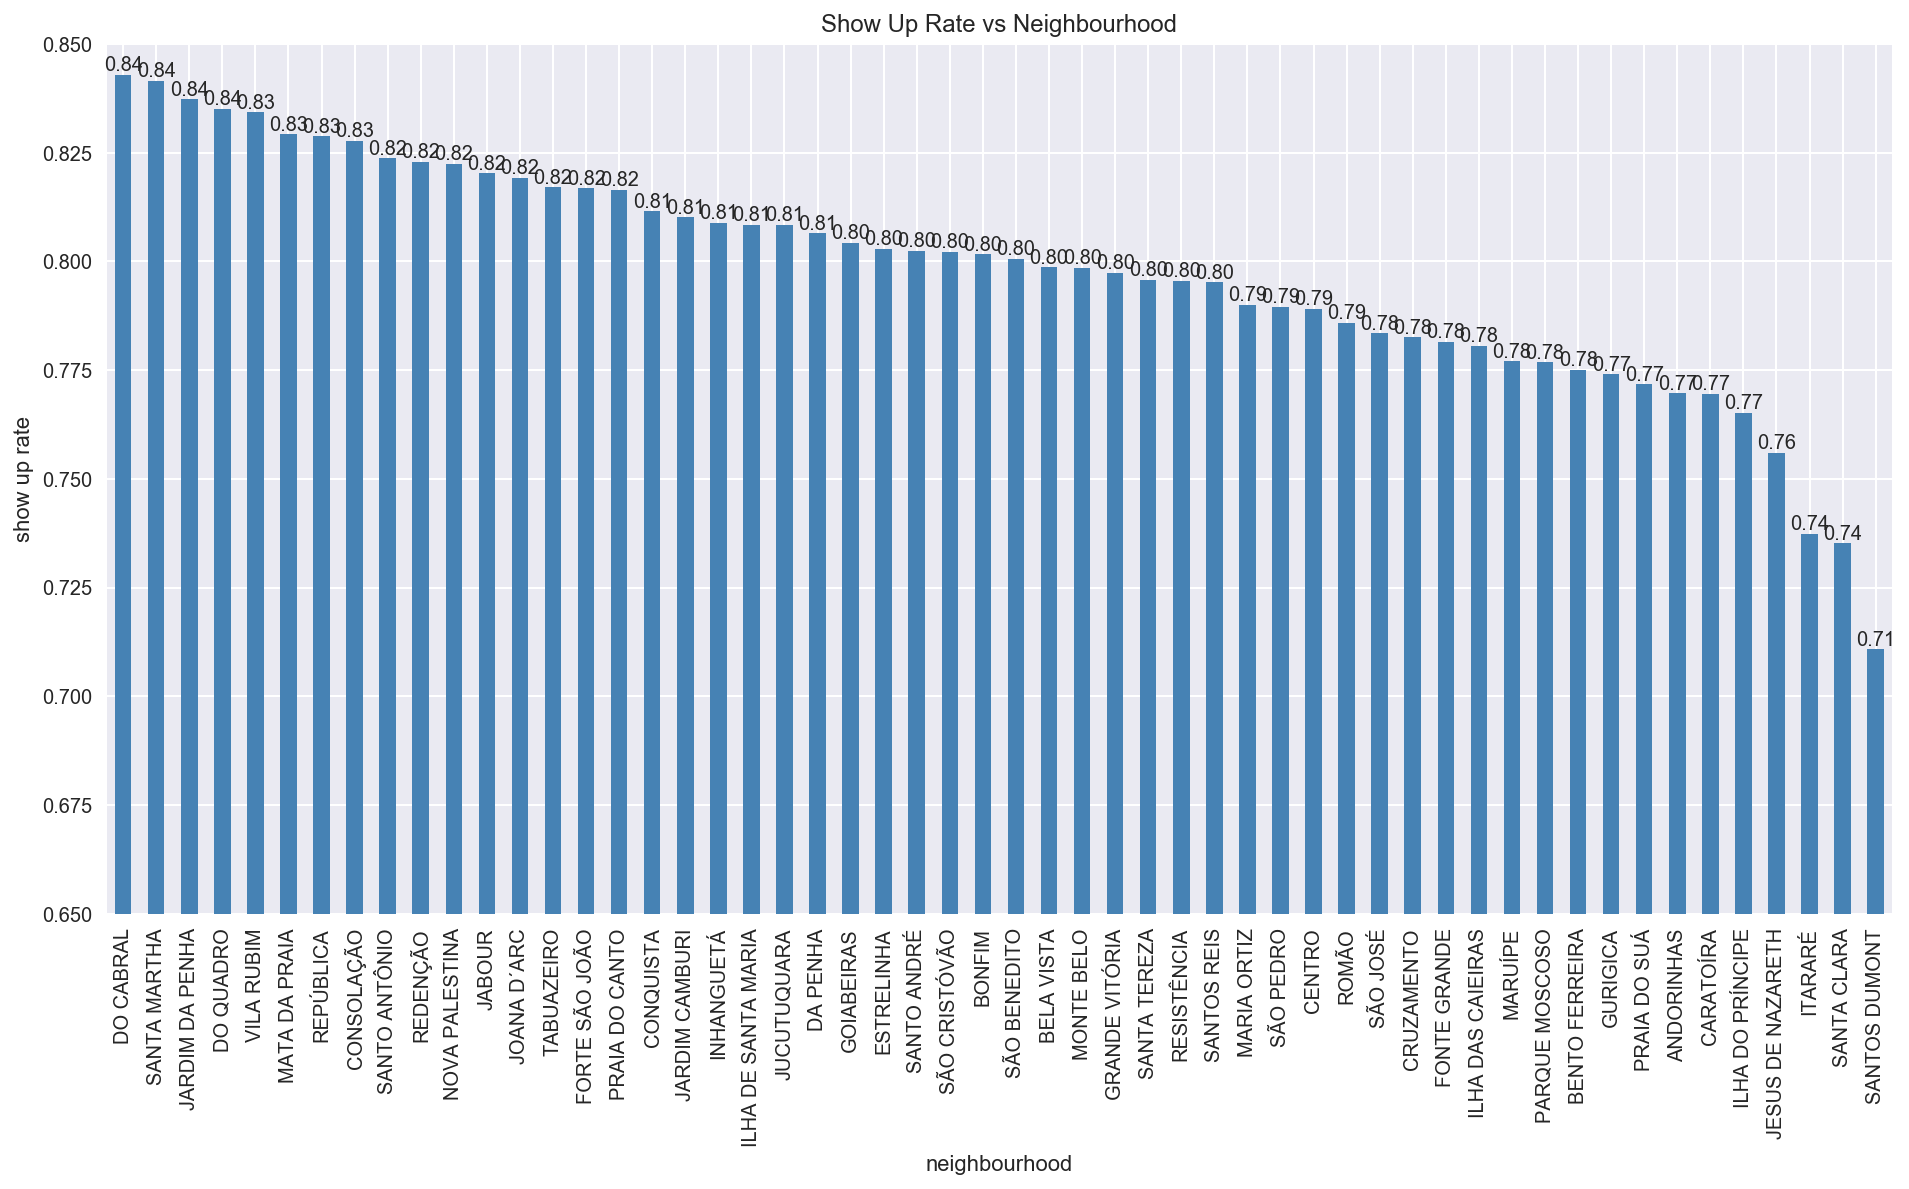

In [26]:
# 设置画布大小
plt.figure(figsize=(16,8))

# 获取数据
fig_data = clean_data.groupby('neighbourhood').if_show.mean()

# 将街区就诊率按照从大到小排列
ind = fig_data.sort_values(ascending=False).index
fig_data[ind].plot(kind='bar', color='steelblue')

# 设置y轴显示范围
plt.ylim((0.65, 0.85)) 
plt.title('Show Up Rate vs Neighbourhood')
plt.ylabel('show up rate')

# 添加数值大小,保留两位小数
for i in range(len(ind)):
    plt.text(i, fig_data[ind][i], '%0.2f'%fig_data[ind][i], ha='center', va= 'bottom')
    
plt.show();

就诊率和医院位置具有相关性，不同的街区就诊率差别很大，就诊率最高的街区为84%，就诊率最低的街区为71%，相差13%。

#### 3.4.6 是否患糖尿病

diabetes
0    102583
1      7943
Name: if_show, dtype: int64


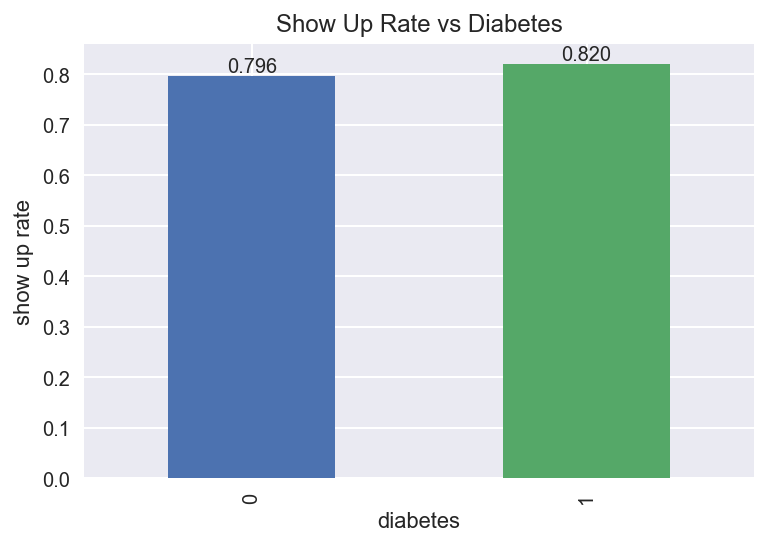

In [27]:
# 打印具体数据
print(data.groupby('diabetes').if_show.count())

# 获取统计数据
fig_data = data.groupby('diabetes').if_show.mean()

fig_data.plot(kind='bar')
plt.title('Show Up Rate vs Diabetes')
plt.ylabel('show up rate')

# 添加数值大小,保留两位小数
for x,y in fig_data.items():
    plt.text(x, y, '%.3f'%y, ha='center', va= 'bottom')

患糖尿病的病人的就诊率比没有患糖尿病的病人的就诊率高出3.4%，说明就诊率和是否患糖尿病之间具有相关性。

#### 3.4.7 性别

gender
F    71839
M    38687
Name: if_show, dtype: int64
gender
F    0.796851
M    0.800321
Name: if_show, dtype: float64


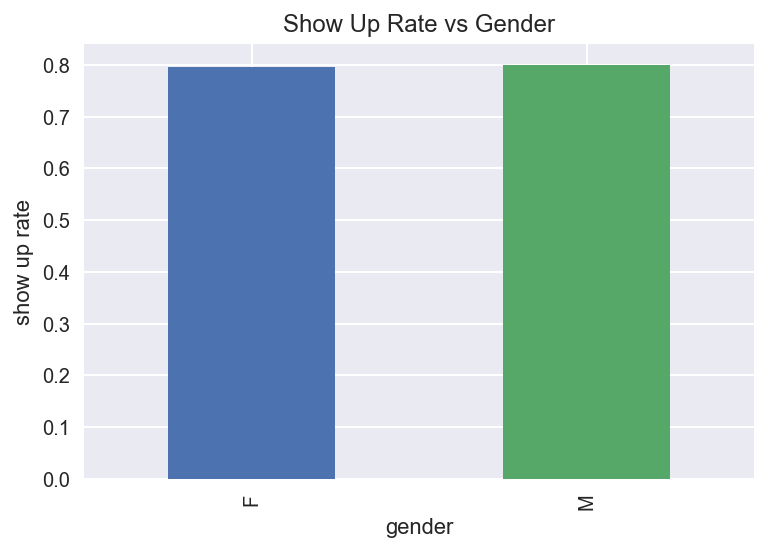

In [28]:
# 打印具体数据
print(data.groupby('gender').if_show.count())
print(data.groupby('gender').if_show.mean())

# 获取统计数据
fig_data = data.groupby('gender').if_show.mean()

fig_data.plot(kind='bar')
plt.title('Show Up Rate vs Gender')
plt.ylabel('show up rate')
plt.show()

不同性别的就诊率几乎相同，说明性别与就诊率之间没有关联。

#### 3.4.8 是否酗酒

alcoholism
0    107166
1      3360
Name: if_show, dtype: int64
alcoholism
0    0.798052
1    0.798512
Name: if_show, dtype: float64


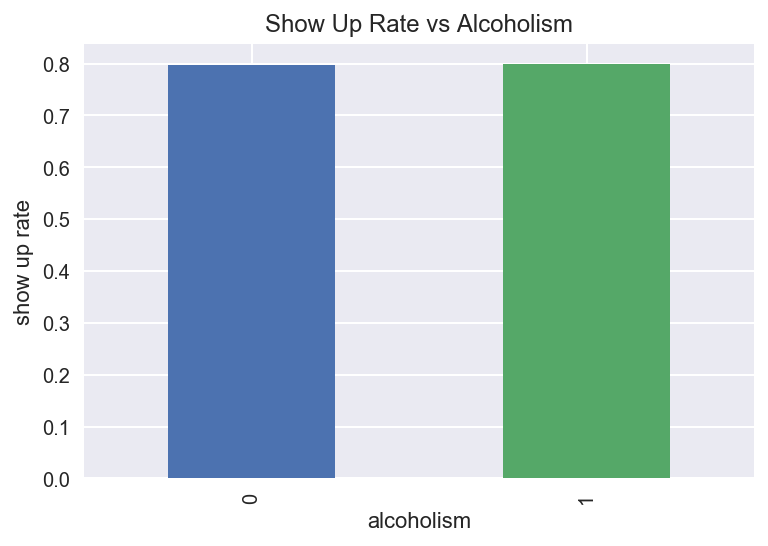

In [29]:
# 打印具体数据
print(data.groupby('alcoholism').if_show.count())
print(data.groupby('alcoholism').if_show.mean())

# 获取统计数据
fig_data = data.groupby('alcoholism').if_show.mean()

fig_data.plot(kind='bar')
plt.title('Show Up Rate vs Alcoholism')
plt.ylabel('show up rate')
plt.show()

是否酗酒的就诊率几乎相同，说明是否酗酒与就诊率之间没有关联。

<a id='conclusions'></a>
## 四. 结论

通过以上探索性分析可知：
- 预约数量集中在工作日，周一到周三每天的预约数量多于周四，周五的预约。
- 预约数量从年龄上来看，集中在0到60岁年龄段。
- 预约数量从性别上来看，集中为女性，是男性数量的2倍。
- 就诊率与**性别**，**是否酗酒**无关；与**是否有短信提醒**，**是否享受福利保障**，**是否患高血压**，**医院地点（街区）**，**是否患糖尿病**有关。其中就诊率与**是否收到短信**，**医院地点**相关性较强，与**是否享受福利保障**，**是否患高血压**，**是否患糖尿病**相关性较弱。

<a id='afterword'></a>
## 五. 后记
以上仅为描述性统计分析所得结论，后续需使用推论统计学或机器学习等知识进一步完善分析结果。

_附参考网站:_
- <a href='https://www.kaggle.com/joniarroba/noshowappointments'>Kaggle</a>
- <a href='http://pythonspot.com/en/matplotlib-bar-chart/'>Matplotlib Bar chart</a>